библиотеки

In [169]:
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import numpy as np
import re

функции

In [170]:
def fill_f2b(df):#для заполнения пропусков в старых значениях известными значениями из новых, после наоборот
    df["user_id"]=df["client_id"]
    df=df.sort_values(by=["client_id","report_date"]).groupby("user_id").ffill().bfill()
    #print(df)
    return df
def fill_b2f(df):#^только наоборот
    df["user_id"]=df["client_id"]
    df=df.sort_values(by=["client_id","report_date"]).groupby("user_id").bfill().ffill()
    #print(df)
    return df
def mt_cols(df,threshold):#убирает колонки с пропусками выше threshold(если threshold=0.999, убираем где заполнено менее .1%)
    df.drop_duplicates()
    df.dropna(how="all",axis=1,inplace=True)
    df=df.loc[:,((df==0)|(df.isnull())).mean()<threshold]
    return df
def float2int(df):#как можем переводим float в int
    float_columns=df.select_dtypes(include=np.number).columns
    for col in float_columns:
        temp=df[col].fillna(0)
        if temp.apply(lambda x:x==int(x)).all():
            df[col]=df[col].astype("Int64")
    df=df.loc[:,(df!=0).any(axis=0)]
    return df

для упрощения оброботки в будущем, положим весь код, который обрабатыевает набор данных в функцию

In [171]:
def cleanse(df,name,fill_flag):
    #делим базу на часть флоутов и интов
    df_int=df.select_dtypes(include=["int64"])
    df_float=df.select_dtypes(include=["float64"])
    #обрабатываем инты
    df_int=df_int.astype(float)
    df_int=df_int.drop(["client_id","target"],axis=1)
    df_int.replace("nan",np.nan,inplace=True)
    def merge_columns_with_common_values(df):
        base_toggle=True
        count=0
        unique_cols=[]
        temp_col="col2"
        col_groups={}
        for col in df.columns:
            if col in unique_cols:
                continue
            if col!=df.columns[0]:
                base_toggle=False
            col_groups[col]=[col]
            for next_col in df.columns:
                if col==next_col or next_col in unique_cols:
                    continue
                common_values=list(set(df[col].unique()).intersection(set(df[next_col].unique())))
                if np.nan in common_values:
                    common_values.remove(np.nan)
                match1=re.match(r"([a-zA-Z]+)(\d{1,4})",next_col)
                def calc_jump():
                    if base_toggle:
                        return False
                    else:
                        match=re.match(r"([a-zA-Z]+)(\d{1,4})",temp_col)
                        is_jump=(int(match1.group(2))-int(match.group(2)))>5
                        return is_jump
                if (len(common_values)>=1):
                    if calc_jump():
                        temp_col=next_col
                        break
                    count+=1
                    temp_col=next_col
                    col_groups[col].append(next_col)
                    unique_cols.append(next_col)
                    print(f"merged {col} and {next_col}: common_values = {common_vals}")
                else:
                    if calc_jump():
                        temp_col=next_col
                        break
                    common_vals = list(set(df[temp_col].unique()).intersection(set(df[next_col].unique())))
                    if len(common_vals)>=1:
                        count+=1
                        temp_col=next_col
                        col_groups[col].append(next_col)
                        unique_cols.append(next_col)
                        print(f"merged {col} and {next_col}: common_values = {common_vals}")
                    else:break
            unique_cols.append(col)
        for group_name,group_cols in col_groups.items():
            if len(group_cols)>1:
                df[group_name]=(df[group_cols].bfill(axis=1).iloc[:, 0])
                print(f"merged {group_cols} into {group_name}")
            else:
                df[group_name]=df[group_cols[0]]
        df=df[[col for col in df.columns if col in col_groups]]
        return df,count
    df_int,count=merge_columns_with_common_values(df_int)
    if count==0:
        print("no merged columns?")
    else:
        print(f"{count} merged.")
    #обрабатываем флоуты
    def merge_columns_with_common_values(df):
        base_toggle=True
        count=0
        unique_cols=[]
        temp_col="col4"
        df.replace(["nan",np.float64(0.0),np.float64(1.0)],np.nan,inplace=True)
        col_groups={}
        for col in df.columns:
            if col in unique_cols:
                continue
            if col!=df.columns[1]:
                base_toggle=False
            col_groups[col]=[col]
            for next_col in df.columns:
                if col==next_col or next_col in unique_cols:
                    continue
                common_vals=list(set(df[col].unique()).intersection(set(df[next_col].unique())))
                if np.nan in common_vals:
                    common_vals.remove(np.nan)
                match1=re.match(r"([a-zA-Z]+)(\d{1,4})",next_col)
                def calc_jump():
                    if base_toggle==True:
                        return False
                    else:
                        match=re.match(r"([a-zA-Z]+)(\d{1,4})",temp_col)
                        is_jump=((int(match1.group(2))-int(match.group(2)))>5)
                        return is_jump
                if len(common_vals)>=1:
                    if calc_jump():
                        temp_col=next_col
                        break
                    count+=1
                    temp_col=next_col
                    col_groups[col].append(next_col)
                    unique_cols.append(next_col)
                    print(f"merged {col} and {next_col}: common_values = {common_vals}")
                else:
                    if calc_jump():
                        temp_col=next_col
                        break
                    common_vals=list(set(df[temp_col].unique()).intersection(set(df[next_col].unique())))
                    if len(common_vals)>=1:
                        count+=1
                        temp_col=next_col
                        col_groups[col].append(next_col) 
                        unique_cols.append(next_col) 
                        print(f"merged {col} and {next_col}: common_values = {common_vals}")
                    else:
                        break
            unique_cols.append(col)
        for group_name,group_cols in col_groups.items():
            if len(group_cols)>1:
                df[group_name]=df[group_cols].bfill(axis=1).iloc[:,0]
                print(f"merged {group_cols} into {group_name}")
            else:
                df[group_name]=df[group_cols[0]]
        df=df[[col for col in df.columns if col in col_groups]]
        return df,count
    df_float,count=merge_columns_with_common_values(df_float)
    if count==0:
        print("no merged columns?")
    else:
        print(f"{count} merged.")
    #соединяем обратно 
    df_unsorted=pd.concat([df["report_date"],df["client_id"],df["target"]],axis=1)
    df_unsorted=pd.concat([df_unsorted,df_int,df_float],axis=1)
    #сортируем
    order_dict={}
    order_list=["report_date","client_id","target"]
    columns=df_unsorted.columns
    for column in columns:
        if "col" in column:
            order_dict[column]=int(re.match(r"([a-zA-Z]+)(\d{1,4})", column).group(2))
    sorted_columns = {k:v for k,v in sorted(order_dict.items(),key=lambda item:item[1])}
    for k in sorted_columns:
        order_list.append(k)
    df=df_unsorted[order_list]
    #переводим дату в формат даты
    df["report_date"]=pd.to_datetime(df["report_date"],format=r"%Y-%m-%d")
    df.dropna(how='all',axis=1,inplace=True)
    #выводим 3 csv-шника, по разному заполненных
    df.drop("report_date",axis=1).to_csv(f"{name}_m.csv",index=False)
    if fill_flag:
        fill_f2b(df).drop("report_date",axis=1).to_csv(f"{name}_m_f2b.csv",index=False)
        fill_b2f(df).drop("report_date",axis=1).to_csv(f"{name}_m_b2f.csv",index=False)

считываем данные

In [172]:
df_train=pd.read_csv("train.csv")
df_valid=pd.read_csv("valid.csv")

C:\Users\mesnevi\AppData\Local\Temp\ipykernel_25088\679712079.py:1: DtypeWarning: Columns (51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,131,132,133,135,136,139,140,141,142,143,144,145,146,147,148,149,151,152,155,156,157,158,159,160,161,163,164,165,167,168,169,171,172,173,174,175,176,177,178,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,223,224,227,239,240,241,242,243,244,245,246,459,460,461,467,468,469,515,516,523,524,531,532,539,540,547,548,555,556,563,564,565,567,571,572,573,575,579,580,581,582,583,587,588,595,596,603,604,611,612,613,615,795,796,797,799,1031,1032,1033,1034,1035,1036,1037,1039,1040,1041,1042,1043,1044,1045,1047,1048,1049,1050,1051,1052,1055,1056,1057,1058,1059,1060,1063,1064,1065,1067,1068,1069,1072,1073,1074,1075,1076,1077,1078,1172,1173,1174,1176,1177,1178,1179,1180,1181,1182,1275,1276,1277,1278,1279,1280,1281,1282,1447,1448,1449,14

далее, делаем функцию для обращения к функции несколькими способами, что бы вышло 5 баз

In [173]:
def dupe(df,name):
    cleanse(df,name,fill_flag=True)
    cleanse(fill_f2b(df),f"{name}_f2b",fill_flag=False)
    cleanse(fill_b2f(df),f"{name}_b2f",fill_flag=False)

обрабатываем оба датасета

In [174]:
dupe(df_train,"train")
dupe(df_valid,"valid")

no merged columns?
merged col2 and col3: common_values = [0.6785714285714286]
merged col2 and col4: common_values = [0.6785714285714286]
merged col5 and col6: common_values = [7464071.0]
merged col5 and col7: common_values = [7464071.0]
merged col5 and col8: common_values = [7464071.0]
merged col5 and col9: common_values = [7464071.0]
merged col5 and col10: common_values = [7464071.0]
merged col5 and col11: common_values = [7464071.0]
merged col5 and col12: common_values = [7464071.0]
merged col5 and col13: common_values = [7464071.0]
merged col5 and col14: common_values = [7464071.0]
merged col5 and col15: common_values = [7464071.0]
merged col5 and col16: common_values = [7464071.0]
merged col5 and col17: common_values = [7464071.0]
merged col5 and col18: common_values = [7464071.0]
merged col5 and col19: common_values = [7464071.0]
merged col5 and col20: common_values = [7464071.0]
merged col5 and col21: common_values = [7464071.0]
merged col5 and col22: common_values = [7464071.0]


делаем baseline модель и смотрим, как у неё  получается

In [175]:
df_train_base=df_train.select_dtypes(exclude="object").fillna(0)
df_valid_base=df_valid.select_dtypes(exclude="object").fillna(0)

функция для автоматического обучения модели по данным датасетам

In [176]:
def educate(train_df,valid_df):
    #разделяем первый датасет на train и test
    X=train_df.drop(["target","client_id"],axis=1)
    y=train_df["target"]
    X_train,X_test,y_train,y_test=tts(X,y,random_state=42,shuffle=False)
    #для предсказания на валидационном датасете
    X_val=valid_df.drop(["target","client_id"], axis=1)
    y_val=valid_df["target"]
    #убираем колонки которых не хватает в одном из датасетов
    X_train=X_train.drop(set(X_train.columns)-set(X_test.columns),axis=1)
    X_train=X_train.drop(set(X_train.columns)-set(X_val.columns),axis=1)
    X_test=X_test.drop(set(X_test.columns)-set(X_train.columns),axis=1)
    X_val=X_val.drop(set(X_val.columns)-set(X_train.columns),axis=1)
    #обучение модели на train части
    model=RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    #предсказание на test
    y_test_pred_proba=model.predict_proba(X_test)[:,1]
    test_roc_auc=metrics.roc_auc_score(y_test,y_test_pred_proba)
    print(f"ROC-AUC на тестовой части: {test_roc_auc:.2f}")
    #предсказывание на valid
    y_val_pred_proba = model.predict_proba(X_val)[:,1]
    val_roc_auc = metrics.roc_auc_score(y_val,y_val_pred_proba)
    print(f"ROC-AUC на валидационном датасете: {val_roc_auc:.2f}")
    return y_test,y_test_pred_proba,y_val,y_val_pred_proba

In [177]:
y_test,y_test_pred_proba,y_val,y_val_pred_proba=educate(df_train_base,df_valid_base)

ROC-AUC на тестовой части: 0.95
ROC-AUC на валидационном датасете: 0.72


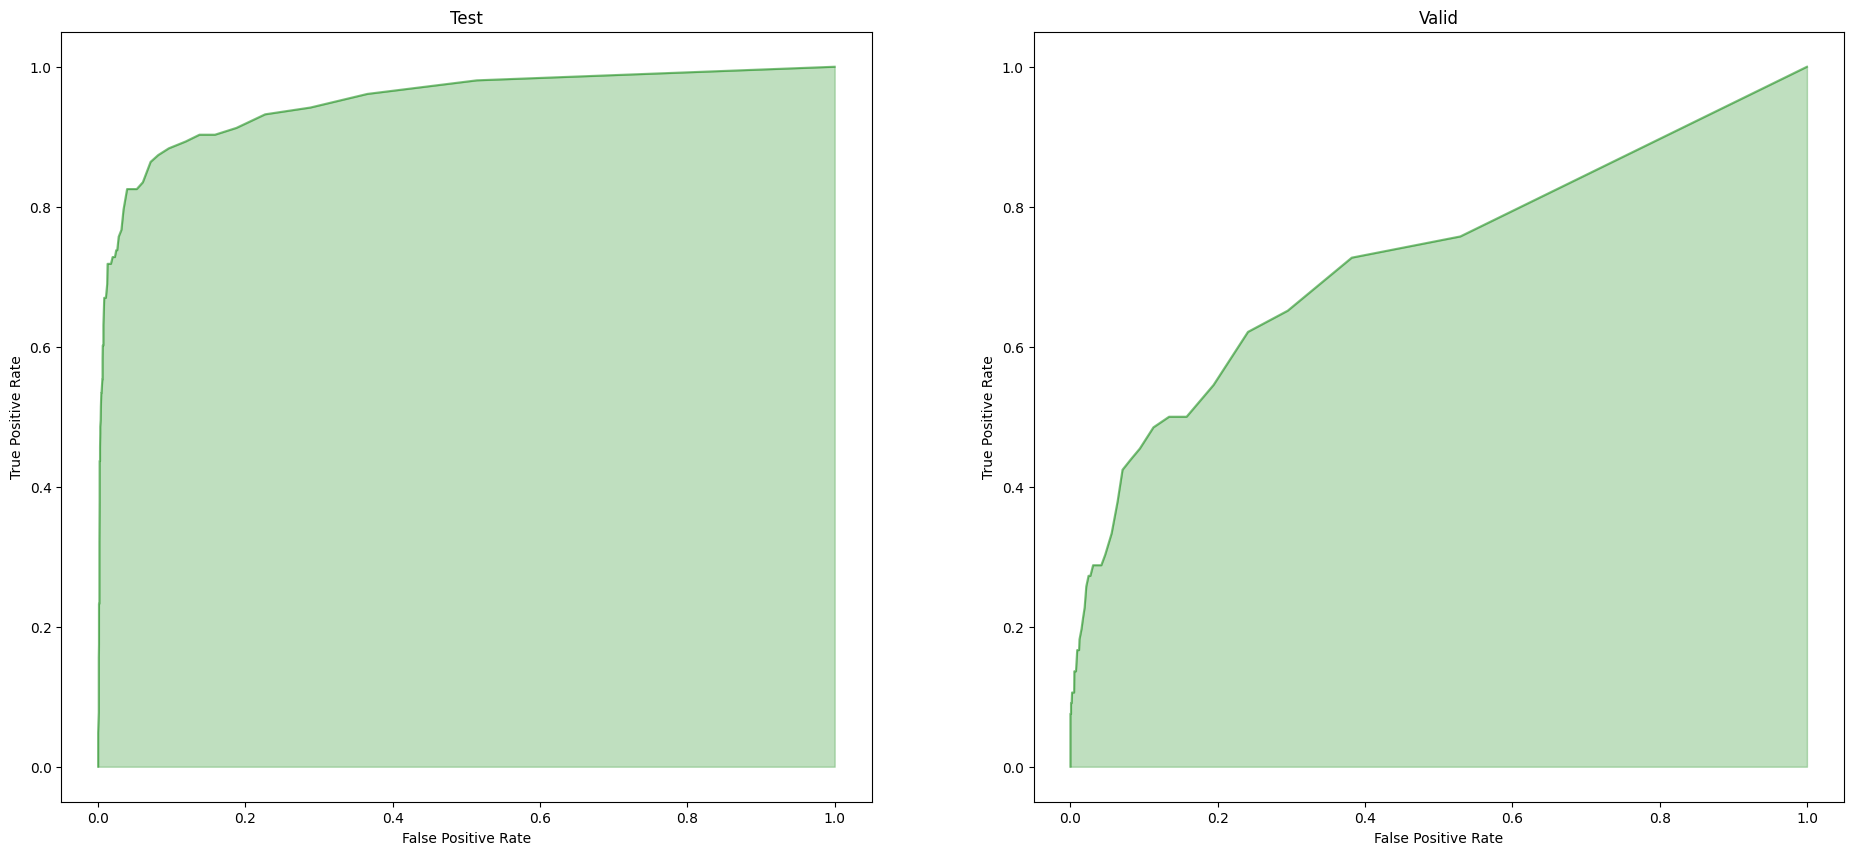

In [199]:
_,axs=plt.subplots(1,2,figsize=(23, 10))
#test
fpr,tpr,_=metrics.roc_curve(y_test,y_test_pred_proba)
axs[0].plot(fpr, tpr,color="green",alpha=0.5)
axs[0].fill_between(fpr,tpr,color='green',alpha=0.25)
axs[0].set_ylabel('True Positive Rate')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_title("Test")
#val
fpr,tpr,_=metrics.roc_curve(y_val,y_val_pred_proba)
axs[1].plot(fpr,tpr,color="green",alpha=0.5)
axs[1].fill_between(fpr,tpr,color='green',alpha=0.25)
axs[1].set_ylabel('True Positive Rate')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_title("Valid")
#вывод
plt.show()

теперь читаем ранее заготовленные csv-шники и прогоняем по функции для обучения

In [180]:
train_m,valid_m=pd.read_csv("train_m.csv"),pd.read_csv("valid_m.csv")
m_test,m_test_pred_proba,m_val,m_val_pred_proba=educate(train_m,valid_m)

train_m_f2b,valid_m_f2b=pd.read_csv("train_m_f2b.csv"),pd.read_csv("valid_m_f2b.csv")
m_f2b_test,m_f2b_test_pred_proba,m_f2b_val,m_f2b_val_pred_proba=educate(train_m_f2b,valid_m_f2b)

train_m_b2f,valid_m_b2f=pd.read_csv("train_m_b2f.csv"),pd.read_csv("valid_m_b2f.csv")
m_b2f_test,m_b2f_test_pred_proba,m_b2f_val,m_b2f_val_pred_proba=educate(train_m_b2f,valid_m_b2f)

train_f2b_m,valid_f2b_m=pd.read_csv("train_f2b_m.csv"),pd.read_csv("valid_f2b_m.csv")
f2b_m_test,f2b_m_test_pred_proba,f2b_m_val,f2b_m_val_pred_proba=educate(train_f2b_m,valid_f2b_m)

train_b2f_m,valid_b2f_m=pd.read_csv("train_b2f_m.csv"),pd.read_csv("valid_b2f_m.csv")
b2f_m_test,b2f_m_test_pred_proba,b2f_m_val,b2f_m_val_pred_proba=educate(train_b2f_m,valid_b2f_m)

ROC-AUC на тестовой части: 0.97
ROC-AUC на валидационном датасете: 0.75
ROC-AUC на тестовой части: 0.62
ROC-AUC на валидационном датасете: 0.70
ROC-AUC на тестовой части: 0.63
ROC-AUC на валидационном датасете: 0.62
ROC-AUC на тестовой части: 0.58
ROC-AUC на валидационном датасете: 0.62
ROC-AUC на тестовой части: 0.60
ROC-AUC на валидационном датасете: 0.57


графики

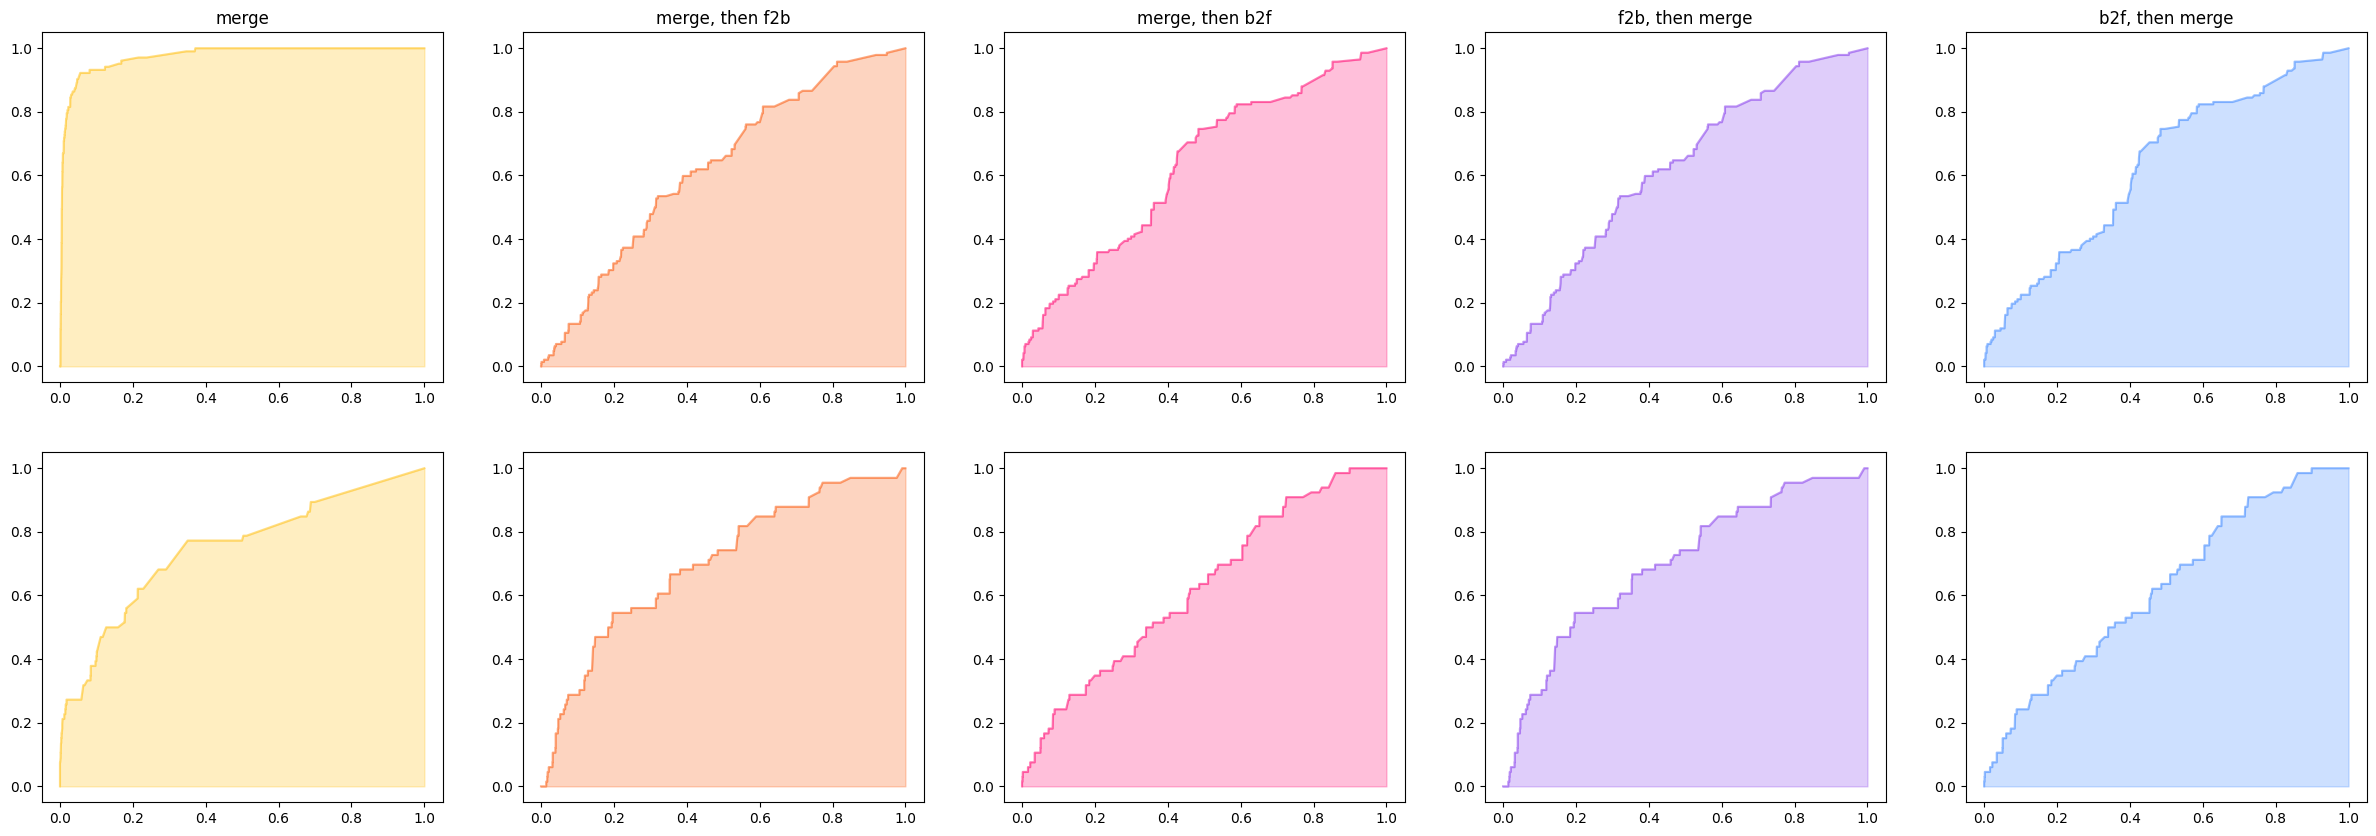

In [206]:
_,axs=plt.subplots(2,5,figsize=(30, 10))
#test
fpr_m,tpr_m,_=metrics.roc_curve(m_test,m_test_pred_proba)
fpr_m_f2b,tpr_m_f2b,_=metrics.roc_curve(m_f2b_test,m_f2b_test_pred_proba)
fpr_m_b2f,tpr_m_b2f,_=metrics.roc_curve(m_b2f_test,m_b2f_test_pred_proba)
fpr_f2b_m,tpr_f2b_m,_=metrics.roc_curve(m_f2b_test,m_f2b_test_pred_proba)
fpr_b2f_m,tpr_b2f_m,_=metrics.roc_curve(m_b2f_test,m_b2f_test_pred_proba)
axs[0,0].plot(fpr_m,tpr_m,color="#ffbe0b",alpha=0.5)
axs[0,1].plot(fpr_m_f2b,tpr_m_f2b,color="#fb5607",alpha=0.5)
axs[0,2].plot(fpr_m_b2f,tpr_m_b2f,color="#ff006e",alpha=0.5)
axs[0,3].plot(fpr_f2b_m,tpr_f2b_m,color="#8338ec",alpha=0.5)
axs[0,4].plot(fpr_b2f_m,tpr_b2f_m,color="#3a86ff",alpha=0.5)
axs[0,0].fill_between(fpr_m,tpr_m,color="#ffbe0b",alpha=0.25)
axs[0,1].fill_between(fpr_m_f2b,tpr_m_f2b,color="#fb5607",alpha=0.25)
axs[0,2].fill_between(fpr_m_b2f,tpr_m_b2f,color="#ff006e",alpha=0.25)
axs[0,3].fill_between(fpr_f2b_m,tpr_f2b_m,color="#8338ec",alpha=0.25)
axs[0,4].fill_between(fpr_b2f_m,tpr_b2f_m,color="#3a86ff",alpha=0.25)
axs[0,0].set_title("merge")
axs[0,1].set_title("merge, then f2b")
axs[0,2].set_title("merge, then b2f")
axs[0,3].set_title("f2b, then merge")
axs[0,4].set_title("b2f, then merge")
#val
fpr_m,tpr_m,_=metrics.roc_curve(m_val,m_val_pred_proba)
fpr_m_f2b,tpr_m_f2b,_=metrics.roc_curve(m_f2b_val,m_f2b_val_pred_proba)
fpr_m_b2f,tpr_m_b2f,_=metrics.roc_curve(m_b2f_val,m_b2f_val_pred_proba)
fpr_f2b_m,tpr_f2b_m,_=metrics.roc_curve(m_f2b_val,m_f2b_val_pred_proba)
fpr_b2f_m,tpr_b2f_m,_=metrics.roc_curve(m_b2f_val,m_b2f_val_pred_proba)
axs[1,0].plot(fpr_m,tpr_m,color="#ffbe0b",alpha=0.5)
axs[1,1].plot(fpr_m_f2b,tpr_m_f2b,color="#fb5607",alpha=0.5)
axs[1,2].plot(fpr_m_b2f,tpr_m_b2f,color="#ff006e",alpha=0.5)
axs[1,3].plot(fpr_f2b_m,tpr_f2b_m,color="#8338ec",alpha=0.5)
axs[1,4].plot(fpr_b2f_m,tpr_b2f_m,color="#3a86ff",alpha=0.5)
axs[1,0].fill_between(fpr_m,tpr_m,color="#ffbe0b",alpha=0.25)
axs[1,1].fill_between(fpr_m_f2b,tpr_m_f2b,color="#fb5607",alpha=0.25)
axs[1,2].fill_between(fpr_m_b2f,tpr_m_b2f,color="#ff006e",alpha=0.25)
axs[1,3].fill_between(fpr_f2b_m,tpr_f2b_m,color="#8338ec",alpha=0.25)
axs[1,4].fill_between(fpr_b2f_m,tpr_b2f_m,color="#3a86ff",alpha=0.25)
#вывод
plt.show()

по этим графикам, кроме того, что я старался, мало можно понять, но красиво, в итоге лучше всего, себя показала вторая модель, ибо первая переобучилась